In [1]:
import numpy as np
import matplotlib.pyplot as plt

from quantum_systems import construct_psi4_system
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccd import OATDCCD
from coupled_cluster.integrators import GaussIntegrator

In [2]:
class LaserPulse:
    def __init__(self, t0=0, td=5, omega=0.1, E=0.03):
        self.t0 = t0
        self.td = td
        self.omega = omega
        self.E = E  # Field strength

    def __call__(self, t):
        T = self.td
        delta_t = t - self.t0
        return (
            -(np.sin(np.pi * delta_t / T) ** 2)
            * np.heaviside(delta_t, 1.0)
            * np.heaviside(T - delta_t, 1.0)
            * np.cos(self.omega * delta_t)
            * self.E
        )

In [3]:
# Define system paramters
He = """
He 0.0 0.0 0.0
symmetry c1
"""


options = {"basis": "cc-pvdz", "scf_type": "pk", "e_convergence": 1e-8}
omega = 2.873_564_3
E = 100
laser_duration = 5


system = construct_psi4_system(He, options)
system.change_to_hf_basis(tolerance=1e-15, verbose=True)

HF converged to given precision in 13 iterations
Ehf: -2.855160477242741


In [4]:
integrator = GaussIntegrator(np=np, eps=1e-10)
cc_kwargs = dict(verbose=True)
oatdccd = OATDCCD(system, integrator=integrator, np=np, **cc_kwargs)
oatdccd.compute_ground_state()
print(
    "Ground state CCD energy: {0}".format(oatdccd.compute_ground_state_energy())
)

Iteration: 0	Residuals (t): [0.15594719219212616]
Iteration: 1	Residuals (t): [0.031910206918114616]
Iteration: 0	Residuals (l): [0.15062129737537192]
Iteration: 1	Residuals (l): [0.030640545890612592]

Iteration: 0

Residual norms: rd = 0.0022340534160096774
Residual norms: ru = 0.0022344179296765305
Iteration: 0	Residuals (t): [0.0017705590129064742]
Iteration: 1	Residuals (t): [0.00041701768817156487]
Iteration: 2	Residuals (t): [1.1865829348068542e-05]
Iteration: 0	Residuals (l): [0.0017789196844619915]
Iteration: 1	Residuals (l): [0.0004202292930080651]
Iteration: 2	Residuals (l): [1.0958620704093061e-05]

Iteration: 1

Residual norms: rd = 0.00014822035623634984
Residual norms: ru = 0.00014795489061849193
Iteration: 0	Residuals (t): [1.5757622057498548e-05]
Iteration: 0	Residuals (l): [1.5665032503455883e-05]
Changing system basis...
Ground state CCD energy: -2.887594778348553


In [5]:
polarization = np.zeros(3)
polarization[2] = 1
system.set_time_evolution_operator(
    LaserField(
        LaserPulse(td=laser_duration, omega=omega, E=E),
        polarization_vector=polarization,
    )
)

In [6]:
oatdccd.set_initial_conditions()
dt = 1e-2
Tfinal = 10
Nsteps = int(Tfinal / dt) + 1
timestep_stop_laser = int(laser_duration / dt)

In [7]:
time_points = np.linspace(0, Tfinal, Nsteps)
print("Nsteps: %d" % Nsteps)
print("step stop laser: %d" % timestep_stop_laser)
print("dt = {0}".format(dt))

td_energies = np.zeros(len(time_points))
td_energies_imag = np.zeros(len(time_points))
phase = np.zeros(len(time_points), dtype=np.complex128)
norm_t2 = np.zeros(len(time_points))
norm_l2 = np.zeros(len(time_points))
dip_z = np.zeros(len(time_points))
td_energies[0] = oatdccd.compute_energy()

Nsteps: 1001
step stop laser: 500
dt = 0.01


In [8]:
t, l, C, C_tilde = oatdccd.amplitudes

energy = oatdccd.compute_energy()
td_energies[0] = energy.real
td_energies_imag[0] = energy.imag

rho_qp = oatdccd.compute_one_body_density_matrix()
rho_qp_hermitian = 0.5 * (rho_qp.conj().T + rho_qp)

z = system.dipole_moment[2].copy()
z = C_tilde @ z @ C

dip_z[0] = (np.einsum("qp,pq->", rho_qp_hermitian, z)).real

phase[0] = t[0][0]
norm_t2[0] = np.linalg.norm(t[1])
norm_l2[0] = np.linalg.norm(l)

In [9]:
for i, amp in enumerate(oatdccd.solve(time_points)):
    t, l, C, C_tilde = amp
    energy = oatdccd.compute_energy()
    td_energies[i + 1] = energy.real
    td_energies_imag[i + 1] = energy.imag

    rho_qp = oatdccd.compute_one_body_density_matrix()
    rho_qp_hermitian = 0.5 * (rho_qp.conj().T + rho_qp)

    z = system.dipole_moment[2].copy()
    z = C_tilde @ z @ C

    dip_z[i + 1] = (np.einsum("qp,pq->", rho_qp_hermitian, z)).real

    phase[i + 1] = t[0][0]
    norm_t2[i + 1] = np.linalg.norm(t[1])
    norm_l2[i + 1] = np.linalg.norm(l)

    if i % 100 == 0:
        print(f"i = {i}")
        eye = C_tilde @ C
        print(
            "C_tilde C is identity: %s" % np.allclose(eye, np.eye(eye.shape[0]))
        )
        print(
            "rho_qp_hermitian is hermitian: %s"
            % np.allclose(rho_qp_hermitian, rho_qp_hermitian.conj().T)
        )
        print("norm(t2): %g" % np.linalg.norm(t[1]))
        print("norm(l2): %g" % np.linalg.norm(l))

i = 0
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 0.170961
norm(l2): 0.169721
i = 100
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 0.170304
norm(l2): 0.169078
i = 200
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 0.357931
norm(l2): 0.346823
i = 300
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 0.652078
norm(l2): 0.589423
i = 400
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 0.858937
norm(l2): 0.725205
i = 500
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 0.999294
norm(l2): 0.799678
i = 600
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 1.01426
norm(l2): 0.806787
i = 700
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 0.934352
norm(l2): 0.76697
i = 800
C_tilde C is identity: True
rho_qp_hermitian is hermitian: True
norm(t2): 1.01463
norm(l2): 0.806949
i = 900
C_tilde

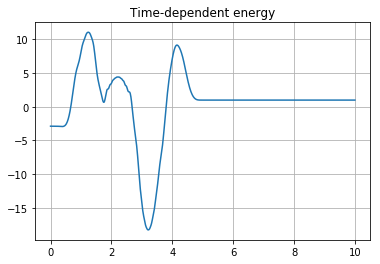

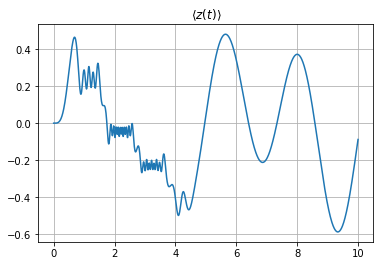

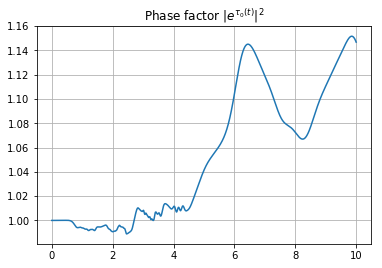

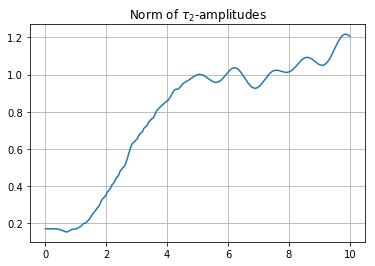

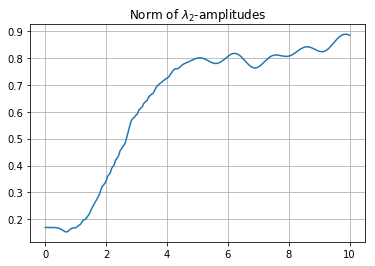

In [10]:
plt.figure()
plt.plot(time_points, td_energies)
plt.title("Time-dependent energy")
plt.grid()

plt.figure()
plt.plot(time_points, dip_z)
plt.title(r"$\langle z(t) \rangle$")
plt.grid()

plt.figure()
plt.plot(time_points, np.abs(np.exp(phase)) ** 2)
plt.title(r"Phase factor $|e^{\tau_0(t)}|^2$")
plt.grid()

plt.figure()
plt.plot(time_points, norm_t2)
plt.title(r"Norm of $\tau_2$-amplitudes")
plt.grid()

plt.figure()
plt.plot(time_points, norm_l2)
plt.title(r"Norm of $\lambda_2$-amplitudes")
plt.grid()

plt.show()